**Step-by-Step Preprocessing Pipeline**

1.	Raw EEG Data: EEG Data is in the .EDF format and is downloaded from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0188629
2.	Filtering: bandpass filtering (0.5-45 Hz) to remove unwanted noise like low-frequency drift or high-frequency noise.
3.	Re-referencing: average re-referencing method
4.	ICA:  ICA to decompose the data and remove any independent components that correspond to artifacts (e.g., ECG, EMG, eye movements).
5.	Epoching: Segment the continuous data into epochs
6.	Autoreject: Autoreject to remove any remaining bad epochs.



# Visualizing the raw EEG signal

Dataset consists of 28 .edf files with 15 minutes of raw eeg signal.14 patients with schizophrenia and 14 healthy controls. Right now we are visualizing and preprocessing only one file.

In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 88.0 MB/s eta 0:00:00


In [310]:
from glob import glob
import os
import mne
mne.set_log_level('error')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk

In [3]:
import zipfile
!unzip /content/drive/MyDrive/Data_files/dataverse_files.zip   # store the downloaded data in the drive and access directly after mounting the drive.

Archive:  /content/drive/MyDrive/Data_files/dataverse_files.zip
  inflating: h01.edf                 
  inflating: h02.edf                 
  inflating: h03.edf                 
  inflating: h04.edf                 
  inflating: h05.edf                 
  inflating: h06.edf                 
  inflating: h07.edf                 
  inflating: h08.edf                 
  inflating: h09.edf                 
  inflating: h10.edf                 
  inflating: h11.edf                 
  inflating: h12.edf                 
  inflating: h13.edf                 
  inflating: h14.edf                 
  inflating: s01.edf                 
  inflating: s02.edf                 
  inflating: s03.edf                 
  inflating: s04.edf                 
  inflating: s05.edf                 
  inflating: s06.edf                 
  inflating: s07.edf                 
  inflating: s08.edf                 
  inflating: s09.edf                 
  inflating: s10.edf                 
  inflating: s11.edf    

In [4]:
all_file_path = glob('/content/*.edf')
print(len(all_file_path))

28


In [322]:
raw = mne.io.read_raw_edf('/content/s01.edf', preload=True)

In [323]:
raw.describe()

<RawEDF | s01.edf, 19 x 211250 (845.0 s), ~30.6 MiB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  Fp2   EEG   µV      -155.35      -4.58       0.00       4.74     100.31
 1  F8    EEG   µV       -80.58      -4.28       0.00       4.44      79.36
 2  T4    EEG   µV       -54.28      -3.67       0.00       3.67      60.55
 3  T6    EEG   µV       -62.54      -3.82       0.00       3.83      38.84
 4  O2    EEG   µV       -60.70      -4.89       0.00       4.59      76.61
 5  Fp1   EEG   µV      -167.58      -4.58       0.00       4.74     164.38
 6  F7    EEG   µV      -106.88      -3.36       0.00       3.37     129.67
 7  T3    EEG   µV      -284.40      -2.60       0.00       2.60    1198.32
 8  T5    EEG   µV       -24.62      -2.60       0.00       2.45      24.77
 9  O1    EEG   µV       -56.42      -4.43       0.00       4.44      45.72
10  F4    EEG   µV       -56.73      -4.13       0.00       4.28      58.57
11  C4    EEG   µV    

In [324]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp2, F8, T4, T6, O2, Fp1, F7, T3, T5, O1, F4, C4, P4, F3, C3, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2004-08-20 12:19:24 UTC
 nchan: 19
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: OJS>
>

In [325]:
#mne.channels.get_builtin_montages()
raw.set_montage('standard_1020')

<RawEDF | s01.edf, 19 x 211250 (845.0 s), ~30.6 MiB, data loaded>

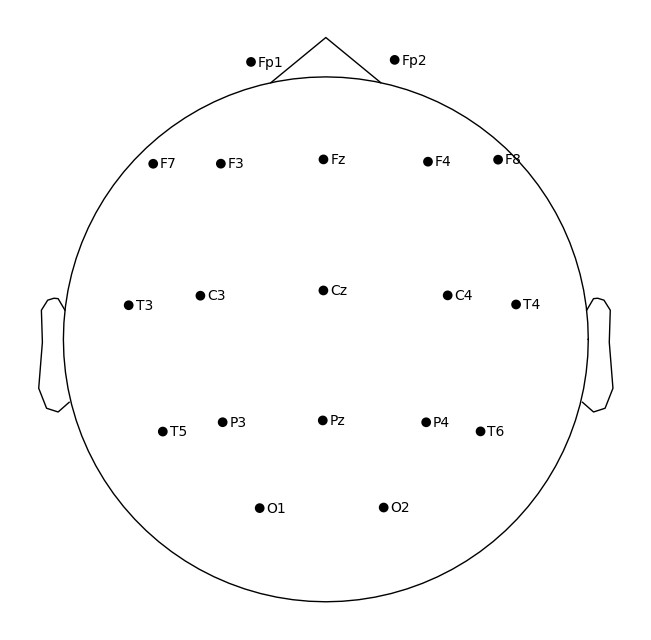

In [326]:
raw.plot_sensors(show_names=True)
plt.show()

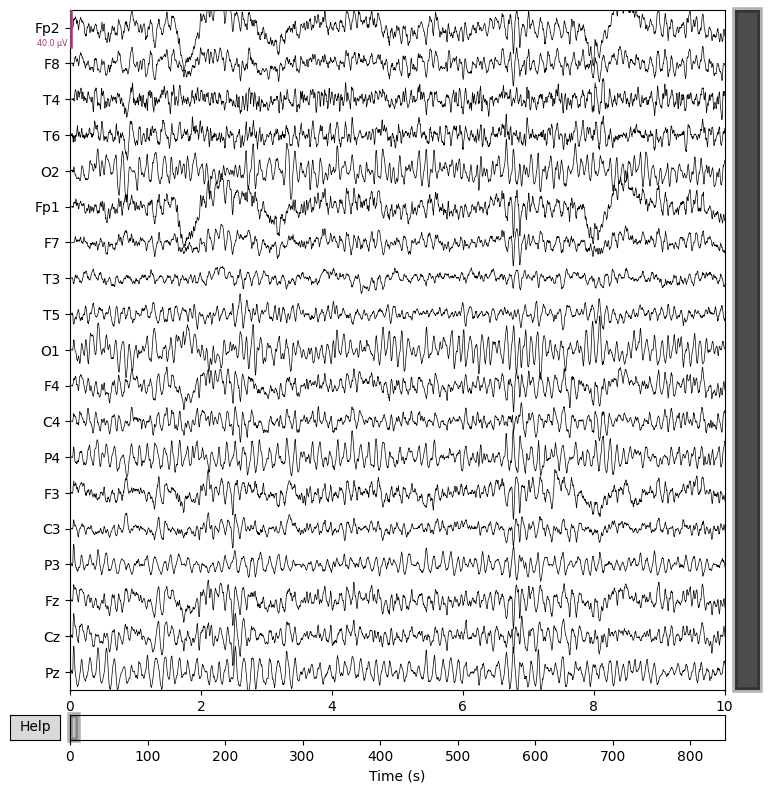

In [327]:
raw.plot();

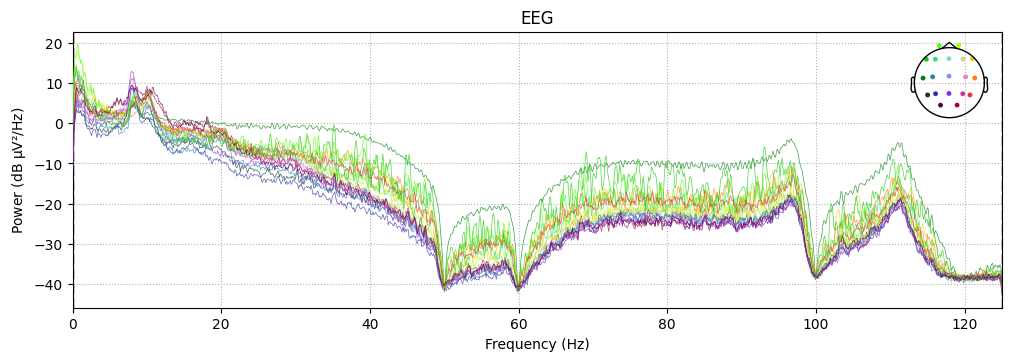

In [328]:
raw.compute_psd().plot();   #power spectral density

# Data Preprocessing

In [61]:
!pip install autoreject   #https://autoreject.github.io/stable/auto_examples/plot_autoreject_workflow.html

In [29]:
!pip install neurokit2   #https://pypi.org/project/neurokit2/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 39.5 MB/s eta 0:00:00


In [329]:
raw.filter(l_freq=0.5,h_freq=45)
raw.set_eeg_reference()

<RawEDF | s01.edf, 19 x 211250 (845.0 s), ~30.6 MiB, data loaded>

In [330]:
ica = mne.preprocessing.ICA(n_components=10, random_state=42)

In [331]:
ica.fit(raw.copy())

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,25 iterations on raw data (211250 samples)
ICA components,10
Available PCA components,19
Channel types,eeg
ICA components marked for exclusion,—


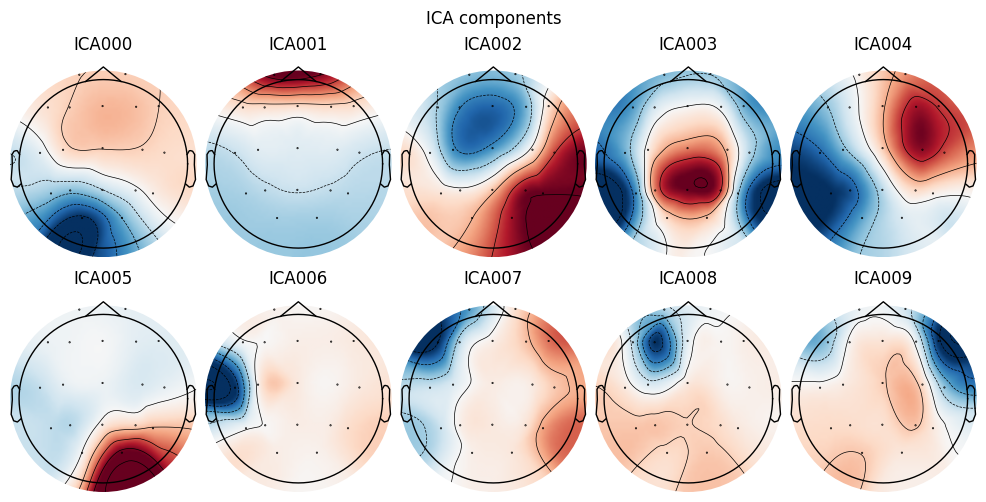

In [332]:
ica.plot_components(outlines='head');

In [333]:
def  find_bad_ecg_indices(data,threshold):

  ecg_signal = data.get_data(picks='Fp1')[0]  # Select a surrogate channel with strong cardiac artifacts
  rpeaks, info = nk.ecg_peaks(ecg_signal, sampling_rate=raw.info['sfreq'])   # Process the signal to detect R-peaks
  rpeaks_array = rpeaks['ECG_R_Peaks'].to_numpy()  # Convert the Series to a NumPy array
  ica_scores = ica.score_sources(raw, target=rpeaks_array)  # Use detected R-peaks to correlate with ICA components
  ecg_indices = [i for i, score in enumerate(ica_scores) if abs(score) > threshold]
  print("ECG-related ICA components:", ecg_indices)
  return ecg_indices

In [334]:
def  find_bad_emg_indices(data,threshold):

  emg_signal = data.get_data(picks='Fp1')[0]  # Extract data from a noisy EEG channel as a proxy for EMG
  emg_cleaned = nk.emg_clean(emg_signal, sampling_rate=raw.info['sfreq'])   # Process EMG signal and detect bursts
  bursts = nk.emg_amplitude(emg_cleaned)
  ica_scores = ica.score_sources(raw, target=bursts)  # Use the EMG bursts to identify noisy ICA components
  emg_indices = [i for i, score in enumerate(ica_scores) if abs(score) > threshold]
  print("EMG-related ICA components:", emg_indices)
  return emg_indices

In [335]:
def  find_saccade_indices(data,threshold):

  eog_signal = data.get_data(picks=['F8', 'F7']).mean(axis=0)
  saccades = nk.eog_findpeaks(eog_signal, sampling_rate=raw.info['sfreq'])

  n_samples = raw.n_times    # Total time points in EEG recording
  saccade_binary = np.zeros(n_samples)  # Create a zero-filled array of length n_samples
  saccade_binary[saccades] = 1  # Mark saccade event locations with 1

  ica_scores = ica.score_sources(raw, target=saccade_binary)  # Score ICA Components Based on Saccades
  saccade_indices = [i for i, score in enumerate(ica_scores) if abs(score) > threshold]
  print(f"Saccade-related ICA components: {saccade_indices}")
  return saccade_indices

In [342]:
eog_indices, _ = ica.find_bads_eog(raw, ch_name=['Fp1', 'Fp2'], threshold=2)
print(f"Blink-related ICA components: {eog_indices}")

ecg_indices  = find_bad_ecg_indices(raw,threshold=0.5)
emg_indices = find_bad_emg_indices(raw, threshold=0.5)
saccade_indices = find_saccade_indices(raw, threshold=0.1)

artifact_indices = list(set(eog_indices + ecg_indices + emg_indices + saccade_indices))
print(f"Artifact components detected: {artifact_indices}")

Blink-related ICA components: [1]
ECG-related ICA components: []
EMG-related ICA components: []
Saccade-related ICA components: []
Artifact components detected: [1]


In [343]:
ica.exclude = artifact_indices

In [344]:
data = ica.apply(raw.copy(), exclude=ica.exclude)

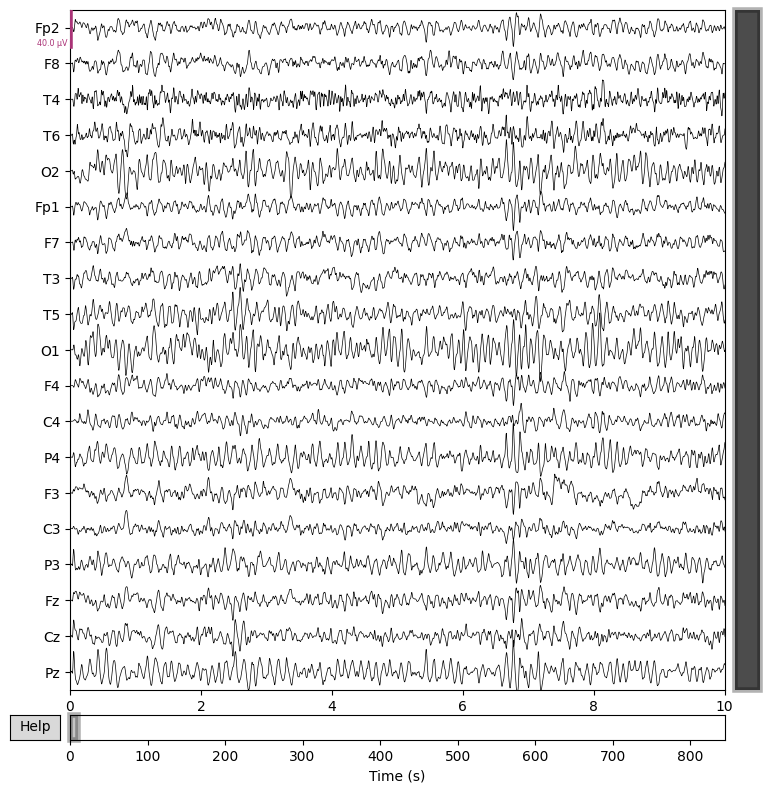

In [345]:
data.plot();

In [346]:
epochs= mne.make_fixed_length_epochs(data,preload=True,duration=5,overlap=1)

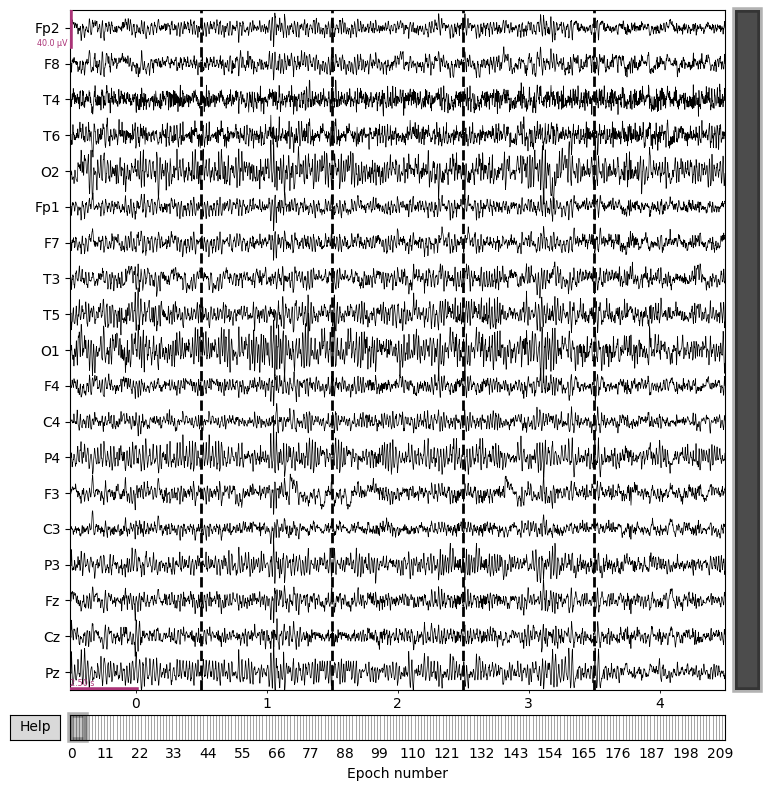

In [347]:
epochs.plot(n_epochs=5);

In [62]:
import autoreject

In [348]:
ar = autoreject.AutoReject(n_interpolate=[1, 2, 3, 4], random_state=11,
                           n_jobs=1, verbose=False)


In [349]:
ar.fit(epochs)
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

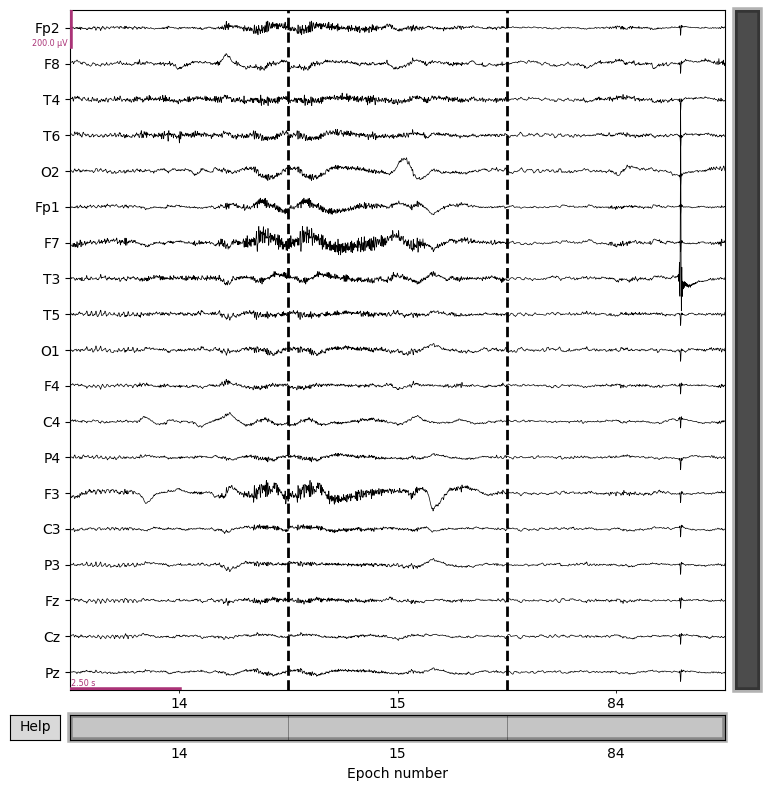

In [350]:
epochs[reject_log.bad_epochs].plot(scalings=dict(eeg=100e-6));

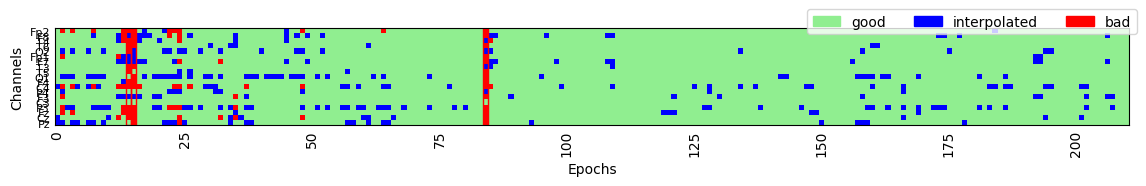

In [351]:
reject_log.plot('horizontal');